# Day 4: Local Regression (LOESS/LOWESS) for Trading

## 🎯 Learning Objectives
- Understand local regression methods
- Implement LOWESS for smoothing and prediction
- Apply to trend detection in prices
- Build trading strategies using local regression

---

## 📚 Theory: Local Regression

### What is LOWESS?
LOcally WEighted Scatterplot Smoothing fits local polynomials using weighted least squares.

### Algorithm
For each point $x_0$:
1. Select neighborhood (fraction $f$ of data)
2. Assign weights based on distance
3. Fit weighted polynomial
4. Predict $\hat{y}(x_0)$

### Weight Function (Tricube)
$$w(u) = \begin{cases} (1 - |u|^3)^3 & |u| < 1 \\ 0 & |u| \geq 1 \end{cases}$$

### Finance Applications
- Trend detection without parametric assumptions
- Regime change identification
- Noise filtering in price series

---

In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)

# Handle MultiIndex columns from yfinance
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

prices = data['Close']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 1254 days


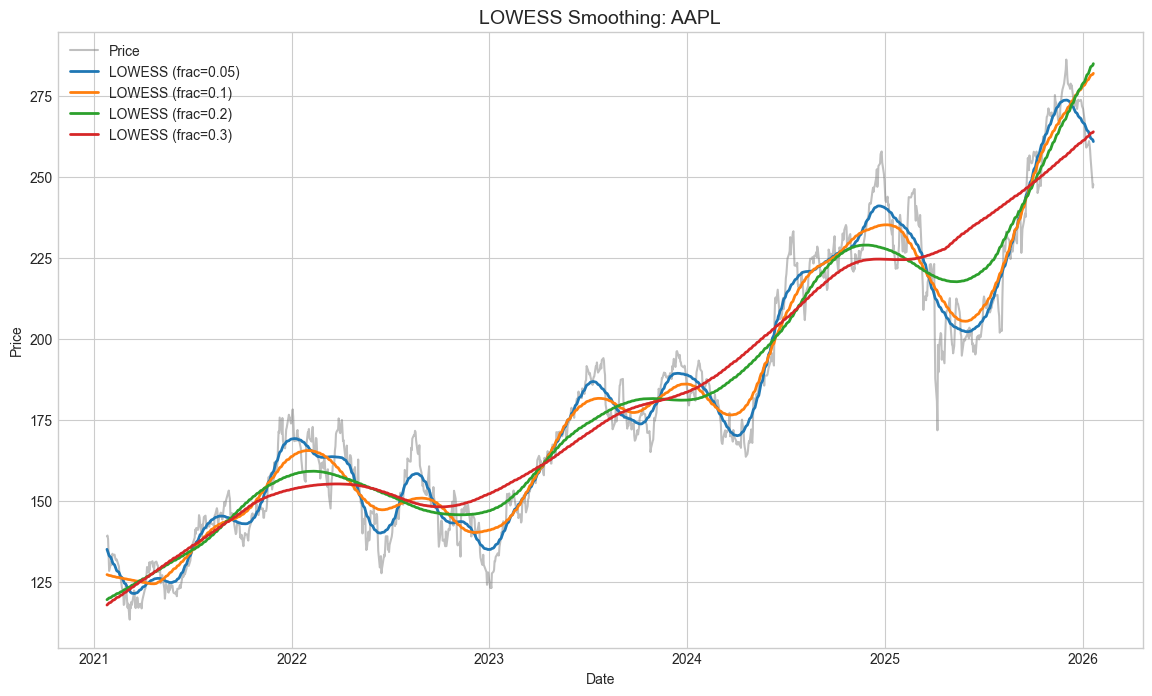

💡 Lower fraction = more responsive, noisier
   Higher fraction = smoother, more lag


In [10]:
# Apply LOWESS with different smoothing parameters
x = np.arange(len(prices))
y = prices.values

# Different fractions (bandwidth)
fractions = [0.05, 0.1, 0.2, 0.3]

plt.figure(figsize=(14, 8))
plt.plot(prices.index, prices.values, 'gray', alpha=0.5, label='Price')

for frac in fractions:
    smoothed = lowess(y, x, frac=frac, return_sorted=False)
    plt.plot(prices.index, smoothed, linewidth=2, label=f'LOWESS (frac={frac})')

plt.title(f'LOWESS Smoothing: {ticker}', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print("💡 Lower fraction = more responsive, noisier")
print("   Higher fraction = smoother, more lag")

In [11]:
# Create trading signals based on LOWESS trend
frac = 0.1  # Reasonable balance
smoothed = lowess(y, x, frac=frac, return_sorted=False)

df = pd.DataFrame(index=prices.index)
df['price'] = prices
df['lowess'] = smoothed
df['return'] = returns

# Signal: Price above LOWESS = bullish
df['signal'] = (df['price'] > df['lowess']).astype(int)

# Trend direction
df['trend'] = np.sign(np.diff(smoothed, prepend=smoothed[0]))
df['trend_signal'] = (df['trend'] > 0).astype(int)

print("\n📊 Signal Distribution:")
print(f"   Price > LOWESS: {df['signal'].mean():.1%}")
print(f"   Trend Up: {df['trend_signal'].mean():.1%}")


📊 Signal Distribution:
   Price > LOWESS: 49.3%
   Trend Up: 66.1%


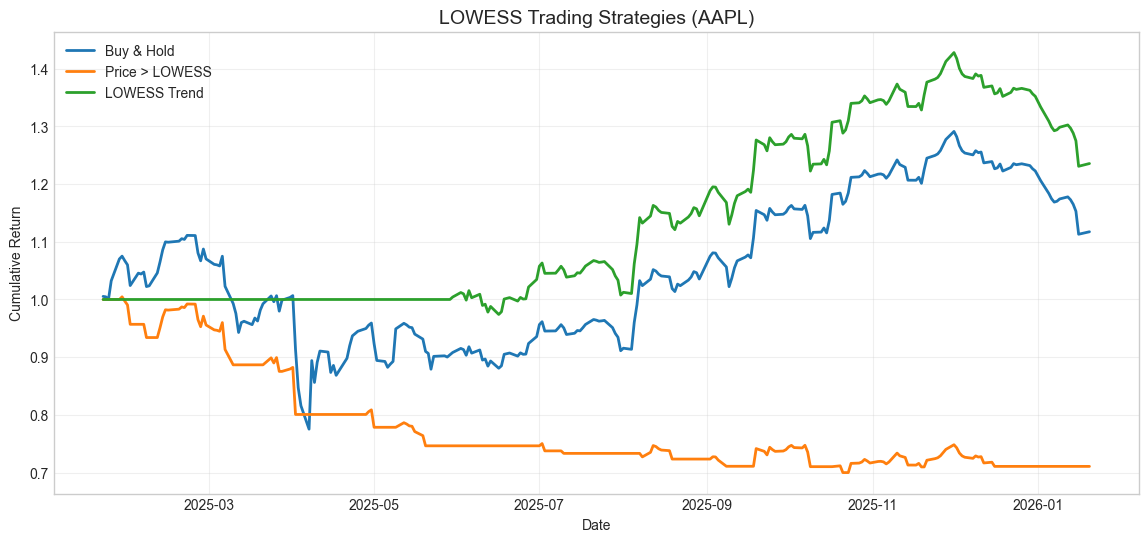

In [12]:
# Backtest trading strategies
df['next_return'] = df['return'].shift(-1)
df = df.dropna()

# Split
split_idx = int(len(df) * 0.8)
test_df = df.iloc[split_idx:].copy()

# Strategies
test_df['price_vs_lowess_return'] = test_df['signal'] * test_df['next_return']
test_df['trend_return'] = test_df['trend_signal'] * test_df['next_return']

# Cumulative
test_df['buy_hold_cum'] = (1 + test_df['next_return']).cumprod()
test_df['price_vs_lowess_cum'] = (1 + test_df['price_vs_lowess_return']).cumprod()
test_df['trend_cum'] = (1 + test_df['trend_return']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(test_df.index, test_df['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(test_df.index, test_df['price_vs_lowess_cum'], label='Price > LOWESS', linewidth=2)
plt.plot(test_df.index, test_df['trend_cum'], label='LOWESS Trend', linewidth=2)
plt.title(f'LOWESS Trading Strategies ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# Performance metrics
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

strategies = [
    ('Buy & Hold', 'next_return', 'buy_hold_cum'),
    ('Price > LOWESS', 'price_vs_lowess_return', 'price_vs_lowess_cum'),
    ('LOWESS Trend', 'trend_return', 'trend_cum')
]

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 55)

for name, ret_col, cum_col in strategies:
    total, sharpe, mdd = calc_metrics(test_df[ret_col], test_df[cum_col])
    print(f"{name:<20} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")


STRATEGY PERFORMANCE

Strategy                Total Ret     Sharpe     Max DD
-------------------------------------------------------
Buy & Hold                 11.74%       0.35    -30.22%
Price > LOWESS            -28.93%      -2.25    -30.32%
LOWESS Trend               23.56%       1.05    -13.80%


In [14]:
# Next day prediction
latest_price = prices.iloc[-1]
latest_lowess = smoothed[-1]
latest_trend = df['trend'].iloc[-1]

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTION FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"\nCurrent Price: ${latest_price:.2f}")
print(f"LOWESS Value: ${latest_lowess:.2f}")
print(f"\nPrice vs LOWESS: {'📈 ABOVE (Bullish)' if latest_price > latest_lowess else '📉 BELOW (Bearish)'}")
print(f"LOWESS Trend: {'📈 UP' if latest_trend > 0 else '📉 DOWN'}")
print(f"\n🎯 Signal: {'LONG' if latest_price > latest_lowess and latest_trend > 0 else 'CAUTION' if latest_price > latest_lowess or latest_trend > 0 else 'STAY OUT'}")


📊 NEXT DAY PREDICTION FOR AAPL

Date: 2026-01-20

Current Price: $247.65
LOWESS Value: $281.95

Price vs LOWESS: 📉 BELOW (Bearish)
LOWESS Trend: 📈 UP

🎯 Signal: CAUTION


---

## 🏢 Real-World Applications

| Company | Local Regression Use Case |
|---------|-------------------------|
| Renaissance | Non-parametric trend detection |
| DE Shaw | Regime identification |
| Bridgewater | Economic cycle analysis |

### Key Interview Points
1. **Why LOWESS?** - No functional form assumptions
2. **Bandwidth selection?** - Cross-validation or domain knowledge
3. **Limitations?** - Computational cost, boundary effects

---
## 📅 Tomorrow: Distance Metrics Deep Dive